In [1]:
%run /home/user/besos/Matthias/tools/imports.ipynb
from tensorflow.keras import regularizers
def preprocess(X, y, standardization=None):
    
    if standardization is None:
        standardization = [StandardScaler() for i in range(2)]
        X = standardization[0].fit_transform(X)
        y = standardization[1].fit_transform(y)
    else:
        X = standardization[0].transform(X)
        y = standardization[1].transform(y)

    return X, y, standardization

def get_model_1(n_params=13, n_neurons=256, alpha=0.03):
    inputs = Input(shape=(n_params))
    hidden = Dense(n_neurons, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(alpha))(inputs)
    outputs = Dense(1, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(alpha))(hidden)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(), loss='mse')
    model.summary()
    
    return model

ann = KerasRegressor(build_fn=get_model_1, epochs=800, verbose=0)
early_stopping = EarlyStopping(monitor='val_loss', patience=80, restore_best_weights=True)

In [2]:
n_cv = 5
cv_scores = np.ndarray((n_cv,2,3))
X, y = read_samples('CAN', param_set=23, limit=10000, output_meter = 'DistrictHeating:Facility')
X, y, standardization = preprocess(X.iloc[:,:13], y)
X_copy, y_copy = np.array_split(X, n_cv), np.array_split(y, n_cv)

for cv in range(n_cv):
    X, y = [pd.DataFrame(X) for X in X_copy], [pd.DataFrame(y) for y in y_copy]
    X_test, y_test = X.pop(cv), y.pop(cv)
    X_train, y_train = pd.concat(X), pd.concat(y)

    estimator = copy.deepcopy(ann)
    history = estimator.fit(X_train, y_train, validation_split=0.2, callbacks=[early_stopping])

    #training scores
    y_pred_train = estimator.predict(X_train)
    y_true = standardization[1].inverse_transform(y_train)
    y_pred = standardization[1].inverse_transform(y_pred_train)
    
    cv_scores[cv, 0, 0] = r2_score(y_true, y_pred) * 100
    cv_scores[cv, 0, 1] = MAPE(y_true, y_pred)
    cv_scores[cv, 0, 2] = RMSPE(y_true, y_pred)
    
    
    #test scores
    y_pred_test = estimator.predict(X_test)
    y_true = standardization[1].inverse_transform(y_test)
    y_pred = standardization[1].inverse_transform(y_pred_test)
    
    cv_scores[cv, 1, 0] = r2_score(y_true, y_pred) * 100
    cv_scores[cv, 1, 1] = MAPE(y_true, y_pred)
    cv_scores[cv, 1, 2] = RMSPE(y_true, y_pred)
   

    
print('Training performance:')
print(f'R2: ({np.mean(cv_scores[:,0,0]):5.2f} +/- {np.std(cv_scores[:,0,0]):5.2f}) %')
print(f'MAPE: ({np.mean(cv_scores[:,0,1]):5.2f} +/- {np.std(cv_scores[:,0,1]):5.2f}) %')
print(f'RMSPE: ({np.mean(cv_scores[:,0,2]):5.2f} +/- {np.std(cv_scores[:,0,2]):5.2f}) %')
print()
print('Test performance:')
print(f'R2: ({np.mean(cv_scores[:,1,0]):5.2f} +/- {np.std(cv_scores[:,1,0]):5.2f}) %')
print(f'MAPE: ({np.mean(cv_scores[:,1,1]):5.2f} +/- {np.std(cv_scores[:,1,1]):5.2f}) %')
print(f'RMSPE: ({np.mean(cv_scores[:,1,2]):5.2f} +/- {np.std(cv_scores[:,1,2]):5.2f}) %')


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               3584      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 3,841
Trainable params: 3,841
Non-trainable params: 0
_________________________________________________________________


W0820 00:13:19.812611 140578870830912 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               3584      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 3,841
Trainable params: 3,841
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               3584      
________________________________________

In [3]:
np.save('model1_scores_CAN_cv', cv_scores)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               3584      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 3,841
Trainable params: 3,841
Non-trainable params: 0
_________________________________________________________________


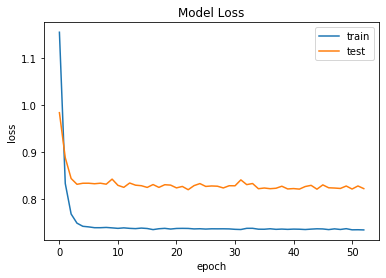

In [4]:
X, y = read_samples('CAN', param_set=23, limit=10000, output_meter = 'DistrictHeating:Facility')
X_train, X_test, y_train,  y_test = train_test_split(X.iloc[:,:13], y, test_size=0.2, shuffle=True)
X_train, y_train, standardization = preprocess(X_train, y_train)
X_test, y_test, _ = preprocess(X_test, y_test, standardization)
estimator = copy.deepcopy(ann)

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
history = estimator.fit(X_train, y_train, validation_split=0.2, callbacks=[early_stopping])

fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
fig.savefig('model1_learning_history.png')

Newfoundland_and_Labrador R2 score: 54.24 %, MAPE: 26.76 %, RMSPE: 36.04 %.
Prince_Edward_Island      R2 score: 22.15 %, MAPE: 35.09 %, RMSPE: 44.31 %.
Nova_Scotia               R2 score: -65.32 %, MAPE: 55.89 %, RMSPE: 68.43 %.
New_Brunswick             R2 score: 52.56 %, MAPE: 27.54 %, RMSPE: 41.91 %.
Quebec                    R2 score: 57.05 %, MAPE: 19.29 %, RMSPE: 25.66 %.
Ontario                   R2 score: 41.64 %, MAPE: 38.42 %, RMSPE: 54.25 %.
Manitoba                  R2 score: 17.80 %, MAPE: 20.43 %, RMSPE: 24.39 %.
Saskatchewan              R2 score: 55.40 %, MAPE: 16.84 %, RMSPE: 21.89 %.
Alberta                   R2 score: 70.75 %, MAPE: 19.51 %, RMSPE: 27.10 %.
British_Columbia          R2 score: -149.71 %, MAPE: 131.50 %, RMSPE: 179.88 %.
Yukon                     R2 score: -36.83 %, MAPE: 31.25 %, RMSPE: 32.47 %.
Northwest_Territories     R2 score: -195.95 %, MAPE: 49.87 %, RMSPE: 50.87 %.
Nunavut                   R2 score: -380.64 %, MAPE: 63.30 %, RMSPE: 63.61 %.

M

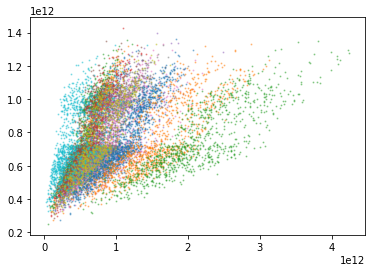

In [5]:
scores = np.ndarray((13,3))
for i, pt in enumerate(CAN_prov_terr.keys()):
    X_test, y_test = read_samples(region=f'CAN_{pt}', param_set=23, output_meter = 'DistrictHeating:Facility')
    X_test, y_test, _ = preprocess(X_test.iloc[:,:13], y_test, standardization)
    y_pred_test = estimator.predict(X_test)
    y_true = standardization[1].inverse_transform(y_test.reshape(len(X_test)))
    y_pred = standardization[1].inverse_transform(y_pred_test.reshape(len(X_test)))
    scores[i, 0] = r2_score(y_true, y_pred) * 100
    scores[i, 1] = MAPE(y_true, y_pred)
    scores[i, 2] = RMSPE(y_true, y_pred)
    plt.scatter(y_true, y_pred, s=1, alpha=0.4)
    print(f'{CAN_prov_terr.get(pt):25s} R2 score: {scores[i, 0]:5.2f} %, MAPE: {scores[i, 1]:5.2f} %, RMSPE: {scores[i, 2]:5.2f} %.')
print()
print(f'{"Mean":25s} R2 score: {np.mean(scores[:,0]):5.2f} %, MAPE: {np.mean(scores[:,1]):5.2f} %, RMSPE: {np.mean(scores[:,2]):5.2f} %.')

In [6]:
np.save('model1_scores_prov_terr', scores)